In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import hdbscan
import seaborn as sns
import statistics

from pycrostates.preprocessing import extract_gfp_peaks
from proof_of_consept import unit_normalize

In [129]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro")
file = data_folder / "sub-001_ses-t1_task-resteyesc_eeg.edf"
processed_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned")
processed_file = processed_folder / "sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set"

raw = mne.io.read_raw_edf(file, preload=True)
raw.set_montage('biosemi64')
cleaned = mne.io.read_epochs_eeglab(processed_file)

raw_highpass = raw.copy().filter(l_freq=0.5, h_freq=None)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=40)
raw_down_sampled = raw_lowpass.copy().resample(sfreq=256)

Extracting EDF parameters from C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro\sub-001_ses-t1_task-resteyesc_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 245759  =      0.000 ...   239.999 secs...


Extracting parameters from C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned\sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set...
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 6759 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 339 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


In [216]:
print(raw_down_sampled.get_data().shape)

(64, 61440)


In [130]:
gfp_peakes = extract_gfp_peaks(raw_down_sampled, min_peak_distance=1)
print(gfp_peakes.get_data().shape)
top_indices = np.argpartition(np.std(gfp_peakes.get_data(), axis=0), -5937)[-5937:]
print(top_indices.shape)
gfp_data = gfp_peakes.get_data()[:, top_indices]
print(gfp_data.shape)

(64, 5937)
(5937,)
(64, 5937)


In [131]:
normalized = unit_normalize(gfp_data.T)
activation = normalized.dot(normalized.T)
absolute_cosine_matrix = np.abs(activation)
#np.fill_diagonal(absolute_cosine_matrix, 0)
print(absolute_cosine_matrix.shape)
distance_matrix = np.abs(absolute_cosine_matrix - 1)

(5937, 5937)


In [132]:
cluster = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=5, min_samples=2)
cluster.fit(distance_matrix)

HDBSCAN(metric='precomputed', min_samples=2)

In [133]:
print(cluster.algorithm)

best


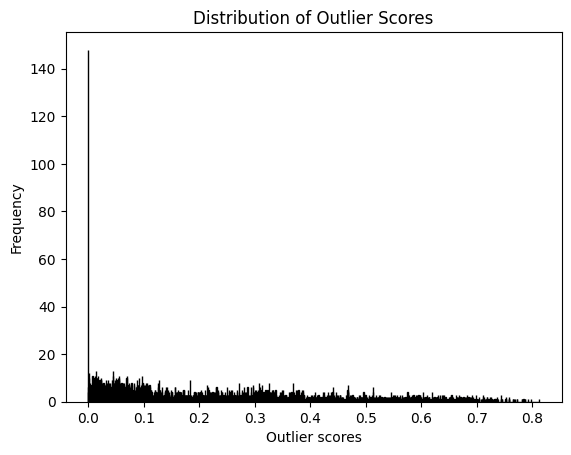

In [134]:
plt.hist(cluster.outlier_scores_, bins=3500, edgecolor='k')
plt.xlabel('Outlier scores')
plt.ylabel('Frequency')
plt.title('Distribution of Outlier Scores')
plt.show()

In [135]:
cluster.leaf_size

40

In [136]:
cluster.cluster_persistence_

array([4.46629917e-03, 8.98277822e-04, 4.22186000e-04, 1.51360244e-03,
       4.51856885e-04, 3.03077782e-02, 1.32884222e-01, 9.13562480e-01,
       9.42242153e-03, 1.02757272e-03, 2.46644723e-03, 1.56542518e-02,
       1.94332170e-03])

<Axes: ylabel='$\\lambda$ value'>

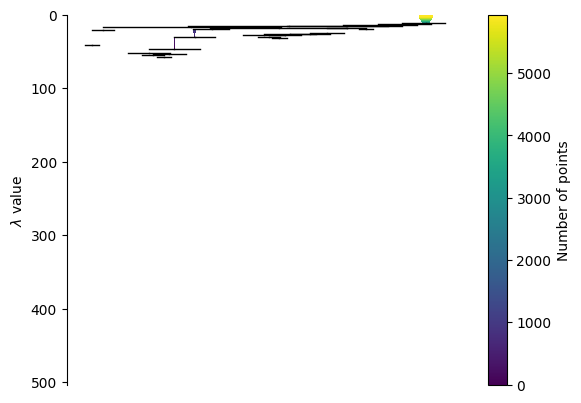

In [137]:
cluster.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

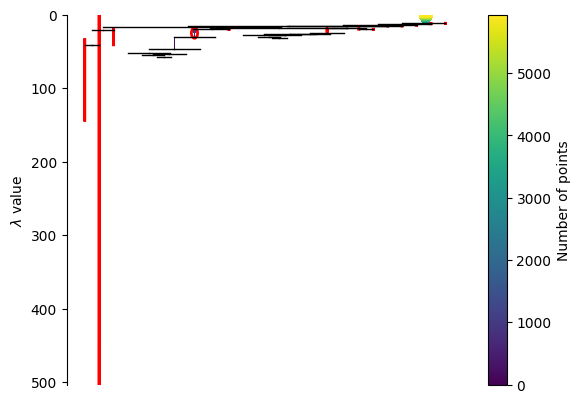

In [138]:
cluster.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

In [139]:
g = cluster.condensed_tree_.to_networkx()
g.number_of_nodes()

5988

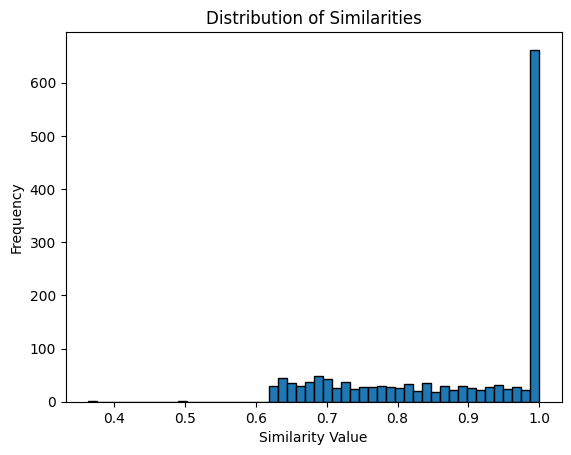

In [140]:
plt.hist(cluster.probabilities_[np.where(cluster.probabilities_>0)], bins=50, edgecolor='k')
plt.xlabel('Similarity Value')
plt.ylabel('Frequency')
plt.title('Distribution of Similarities')
plt.show()

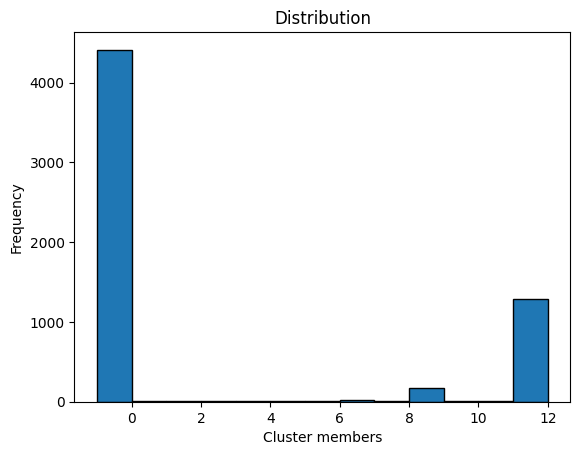

In [141]:
plt.hist(cluster.labels_, bins=13, edgecolor='k')
plt.xlabel('Cluster members')
plt.ylabel('Frequency')
plt.title('Distribution')
plt.show()

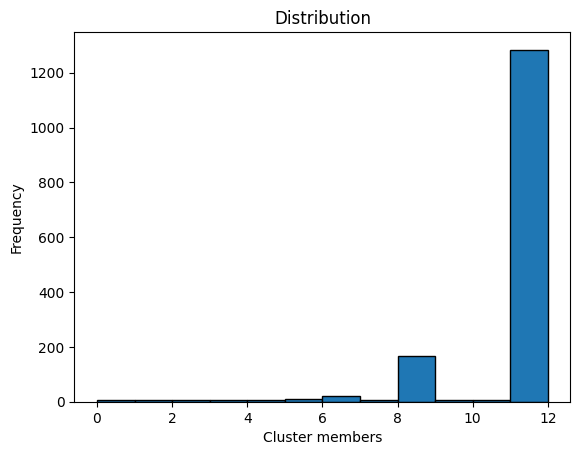

In [197]:
plt.hist(cluster.labels_[np.where(cluster.labels_>-1)], bins=12, edgecolor='k')
plt.xlabel('Cluster members')
plt.ylabel('Frequency')
plt.title('Distribution')
plt.show()

(5937, 64)
(1, 1277, 64)
(1, 64)


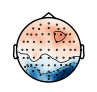

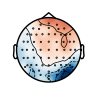

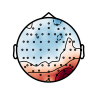

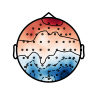

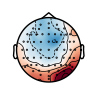

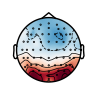

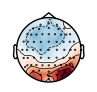

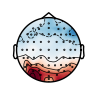

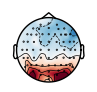

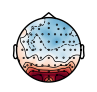

(<matplotlib.image.AxesImage at 0x1798d02cf40>,
 <matplotlib.contour.QuadContourSet at 0x1798d02e8f0>)

In [196]:
c11_indexes = np.where(cluster.labels_==11)
print(normalized.shape)
c11_gfp = normalized[c11_indexes, :]
print(c11_gfp.shape)
c11_gfp.reshape((1277, 64))
print(c11_gfp[:, 0].shape)
mne.viz.plot_topomap(c11_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c11_gfp[:, 10].flatten(), pos=raw.info)
mne.viz.plot_topomap(c11_gfp[:, 44].flatten(), pos=raw.info)
mne.viz.plot_topomap(c11_gfp[:, 87].flatten(), pos=raw.info)
mne.viz.plot_topomap(c11_gfp[:, 103].flatten(), pos=raw.info)
mne.viz.plot_topomap(c11_gfp[:, 509].flatten(), pos=raw.info)
mne.viz.plot_topomap(c11_gfp[:, 654].flatten(), pos=raw.info)
mne.viz.plot_topomap(c11_gfp[:, 899].flatten(), pos=raw.info)
mne.viz.plot_topomap(c11_gfp[:, 1000].flatten(), pos=raw.info)
mne.viz.plot_topomap(c11_gfp[:, 1199].flatten(), pos=raw.info)


(5937, 64)
(1, 166, 64)
(1, 64)


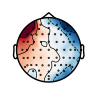

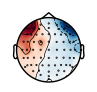

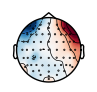

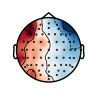

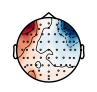

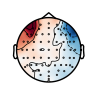

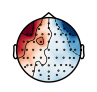

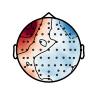

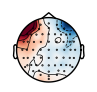

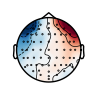

(<matplotlib.image.AxesImage at 0x1798dd54370>,
 <matplotlib.contour.QuadContourSet at 0x1798dd54700>)

In [166]:
c8_indexes = np.where(cluster.labels_==8)
print(normalized.shape)
c8_gfp = normalized[c8_indexes, :]
print(c8_gfp.shape)
c8_gfp.reshape((166, 64))
print(c8_gfp[:, 0].shape)
mne.viz.plot_topomap(c8_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c8_gfp[:, 10].flatten(), pos=raw.info)
mne.viz.plot_topomap(c8_gfp[:, 44].flatten(), pos=raw.info)
mne.viz.plot_topomap(c8_gfp[:, 87].flatten(), pos=raw.info)
mne.viz.plot_topomap(c8_gfp[:, 22].flatten(), pos=raw.info)
mne.viz.plot_topomap(c8_gfp[:, 33].flatten(), pos=raw.info)
mne.viz.plot_topomap(c8_gfp[:, 77].flatten(), pos=raw.info)
mne.viz.plot_topomap(c8_gfp[:, 99].flatten(), pos=raw.info)
mne.viz.plot_topomap(c8_gfp[:, 109].flatten(), pos=raw.info)
mne.viz.plot_topomap(c8_gfp[:, 120].flatten(), pos=raw.info)


(5937, 64)
(1, 20, 64)
(1, 64)


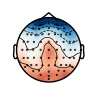

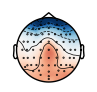

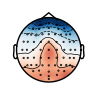

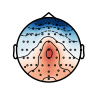

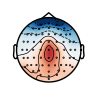

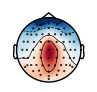

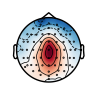

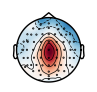

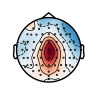

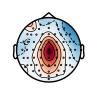

(<matplotlib.image.AxesImage at 0x17986ae0d60>,
 <matplotlib.contour.QuadContourSet at 0x17986ae10f0>)

In [170]:
c6_indexes = np.where(cluster.labels_==6)
print(normalized.shape)
c6_gfp = normalized[c6_indexes, :]
print(c6_gfp.shape)
c6_gfp.reshape((20, 64))
print(c6_gfp[:, 0].shape)
mne.viz.plot_topomap(c6_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c6_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c6_gfp[:, 4].flatten(), pos=raw.info)
mne.viz.plot_topomap(c6_gfp[:, 6].flatten(), pos=raw.info)
mne.viz.plot_topomap(c6_gfp[:, 8].flatten(), pos=raw.info)
mne.viz.plot_topomap(c6_gfp[:, 10].flatten(), pos=raw.info)
mne.viz.plot_topomap(c6_gfp[:, 12].flatten(), pos=raw.info)
mne.viz.plot_topomap(c6_gfp[:, 14].flatten(), pos=raw.info)
mne.viz.plot_topomap(c6_gfp[:, 16].flatten(), pos=raw.info)
mne.viz.plot_topomap(c6_gfp[:, 18].flatten(), pos=raw.info)

(5937, 64)
(1, 5, 64)
(1, 64)


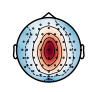

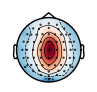

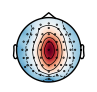

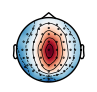

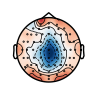

(<matplotlib.image.AxesImage at 0x1798c3eb1c0>,
 <matplotlib.contour.QuadContourSet at 0x1798c3e93f0>)

In [185]:
c0_indexes = np.where(cluster.labels_==0)
print(normalized.shape)
c0_gfp = normalized[c0_indexes, :]
print(c0_gfp.shape)
c0_gfp.reshape((5, 64))
print(c0_gfp[:, 0].shape)
mne.viz.plot_topomap(c0_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c0_gfp[:, 1].flatten(), pos=raw.info)
mne.viz.plot_topomap(c0_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c0_gfp[:, 3].flatten(), pos=raw.info)
mne.viz.plot_topomap(c0_gfp[:, 4].flatten(), pos=raw.info)


(5937, 64)
(1, 6, 64)
(1, 64)


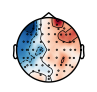

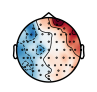

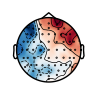

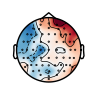

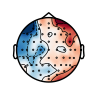

(<matplotlib.image.AxesImage at 0x1798a3cead0>,
 <matplotlib.contour.QuadContourSet at 0x1798a3cc4c0>)

In [187]:
c1_indexes = np.where(cluster.labels_==1)
print(normalized.shape)
c1_gfp = normalized[c1_indexes, :]
print(c1_gfp.shape)
c1_gfp.reshape((6, 64))
print(c1_gfp[:, 0].shape)
mne.viz.plot_topomap(c1_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c1_gfp[:, 1].flatten(), pos=raw.info)
mne.viz.plot_topomap(c1_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c1_gfp[:, 3].flatten(), pos=raw.info)
mne.viz.plot_topomap(c1_gfp[:, 4].flatten(), pos=raw.info)


(5937, 64)
(1, 6, 64)
(1, 64)


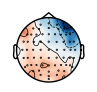

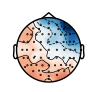

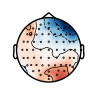

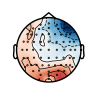

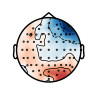

(<matplotlib.image.AxesImage at 0x179a5c3ace0>,
 <matplotlib.contour.QuadContourSet at 0x179a5c3a950>)

In [189]:
c2_indexes = np.where(cluster.labels_==2)
print(normalized.shape)
c2_gfp = normalized[c2_indexes, :]
print(c2_gfp.shape)
c2_gfp.reshape((6, 64))
print(c2_gfp[:, 0].shape)
mne.viz.plot_topomap(c2_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c2_gfp[:, 1].flatten(), pos=raw.info)
mne.viz.plot_topomap(c2_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c2_gfp[:, 3].flatten(), pos=raw.info)
mne.viz.plot_topomap(c2_gfp[:, 4].flatten(), pos=raw.info)

(5937, 64)
(1, 5, 64)
(1, 64)


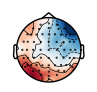

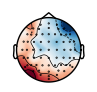

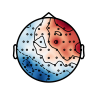

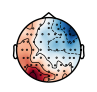

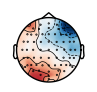

(<matplotlib.image.AxesImage at 0x1798c8ec190>,
 <matplotlib.contour.QuadContourSet at 0x1798c8ecc40>)

In [183]:
c3_indexes = np.where(cluster.labels_==3)
print(normalized.shape)
c3_gfp = normalized[c3_indexes, :]
print(c3_gfp.shape)
c3_gfp.reshape((5, 64))
print(c3_gfp[:, 0].shape)
mne.viz.plot_topomap(c3_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c3_gfp[:, 1].flatten(), pos=raw.info)
mne.viz.plot_topomap(c3_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c3_gfp[:, 3].flatten(), pos=raw.info)
mne.viz.plot_topomap(c3_gfp[:, 4].flatten(), pos=raw.info)

(5937, 64)
(1, 6, 64)
(1, 64)


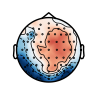

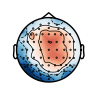

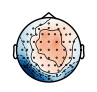

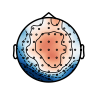

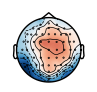

(<matplotlib.image.AxesImage at 0x179a57e4b50>,
 <matplotlib.contour.QuadContourSet at 0x179a5c5c2b0>)

In [192]:
c4_indexes = np.where(cluster.labels_==4)
print(normalized.shape)
c4_gfp = normalized[c4_indexes, :]
print(c4_gfp.shape)
c4_gfp.reshape((6, 64))
print(c4_gfp[:, 0].shape)
mne.viz.plot_topomap(c4_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c4_gfp[:, 1].flatten(), pos=raw.info)
mne.viz.plot_topomap(c4_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c4_gfp[:, 3].flatten(), pos=raw.info)
mne.viz.plot_topomap(c4_gfp[:, 4].flatten(), pos=raw.info)

(5937, 64)
(1, 11, 64)
(1, 64)


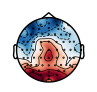

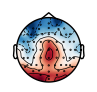

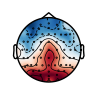

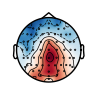

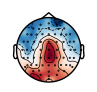

(<matplotlib.image.AxesImage at 0x1798b2eeb60>,
 <matplotlib.contour.QuadContourSet at 0x1798b2ee1d0>)

In [194]:
c5_indexes = np.where(cluster.labels_==5)
print(normalized.shape)
c5_gfp = normalized[c5_indexes, :]
print(c5_gfp.shape)
c5_gfp.reshape((11, 64))
print(c5_gfp[:, 0].shape)
mne.viz.plot_topomap(c5_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c5_gfp[:, 1].flatten(), pos=raw.info)
mne.viz.plot_topomap(c5_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c5_gfp[:, 3].flatten(), pos=raw.info)
mne.viz.plot_topomap(c5_gfp[:, 4].flatten(), pos=raw.info)

(5937, 64)
(1, 5, 64)
(1, 64)


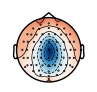

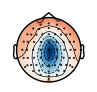

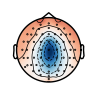

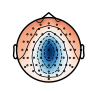

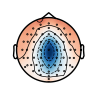

(<matplotlib.image.AxesImage at 0x1798d7453f0>,
 <matplotlib.contour.QuadContourSet at 0x1798d744f10>)

In [199]:
c7_indexes = np.where(cluster.labels_==7)
print(normalized.shape)
c7_gfp = normalized[c7_indexes, :]
print(c7_gfp.shape)
c7_gfp.reshape((5, 64))
print(c7_gfp[:, 0].shape)
mne.viz.plot_topomap(c7_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c7_gfp[:, 1].flatten(), pos=raw.info)
mne.viz.plot_topomap(c7_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c7_gfp[:, 3].flatten(), pos=raw.info)
mne.viz.plot_topomap(c7_gfp[:, 4].flatten(), pos=raw.info)

(5937, 64)
(1, 5, 64)
(1, 64)


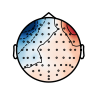

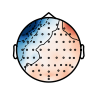

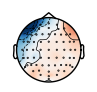

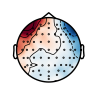

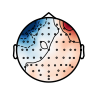

(<matplotlib.image.AxesImage at 0x1798d75c1f0>,
 <matplotlib.contour.QuadContourSet at 0x1798d75dde0>)

In [201]:
c9_indexes = np.where(cluster.labels_==9)
print(normalized.shape)
c9_gfp = normalized[c9_indexes, :]
print(c9_gfp.shape)
c9_gfp.reshape((5, 64))
print(c9_gfp[:, 0].shape)
mne.viz.plot_topomap(c9_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c9_gfp[:, 1].flatten(), pos=raw.info)
mne.viz.plot_topomap(c9_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c9_gfp[:, 3].flatten(), pos=raw.info)
mne.viz.plot_topomap(c9_gfp[:, 4].flatten(), pos=raw.info)

(5937, 64)
(1, 6, 64)
(1, 64)


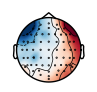

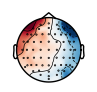

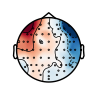

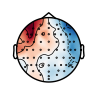

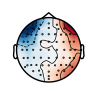

(<matplotlib.image.AxesImage at 0x179832c7430>,
 <matplotlib.contour.QuadContourSet at 0x179832c7a00>)

In [202]:
c10_indexes = np.where(cluster.labels_==10)
print(normalized.shape)
c10_gfp = normalized[c10_indexes, :]
print(c10_gfp.shape)
c10_gfp.reshape((6, 64))
print(c10_gfp[:, 0].shape)
mne.viz.plot_topomap(c10_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c10_gfp[:, 1].flatten(), pos=raw.info)
mne.viz.plot_topomap(c10_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c10_gfp[:, 3].flatten(), pos=raw.info)
mne.viz.plot_topomap(c10_gfp[:, 4].flatten(), pos=raw.info)

(5937, 64)
(1, 7, 64)
(1, 64)


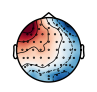

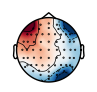

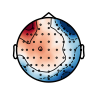

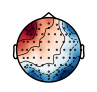

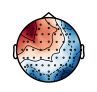

(<matplotlib.image.AxesImage at 0x17984f02fb0>,
 <matplotlib.contour.QuadContourSet at 0x17984f033a0>)

In [204]:
c12_indexes = np.where(cluster.labels_==12)
print(normalized.shape)
c12_gfp = normalized[c12_indexes, :]
print(c12_gfp.shape)
c12_gfp.reshape((7, 64))
print(c12_gfp[:, 0].shape)
mne.viz.plot_topomap(c12_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 1].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 3].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 4].flatten(), pos=raw.info)

In [206]:
outliers_indx = np.where(cluster.labels_==-1)
outliers = normalized[c11_indexes, :].reshape((1277, 64))
activation_o = outliers.dot(outliers.T)
absolute_cosine_matrix_o = np.abs(activation_o)
#np.fill_diagonal(absolute_cosine_matrix, 0)
print(absolute_cosine_matrix_o.shape)
distance_matrix_o = np.abs(absolute_cosine_matrix_o - 1)
cluster = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=5, min_samples=2)
cluster.fit(distance_matrix_o)

(1277, 1277)


HDBSCAN(metric='precomputed', min_samples=2)

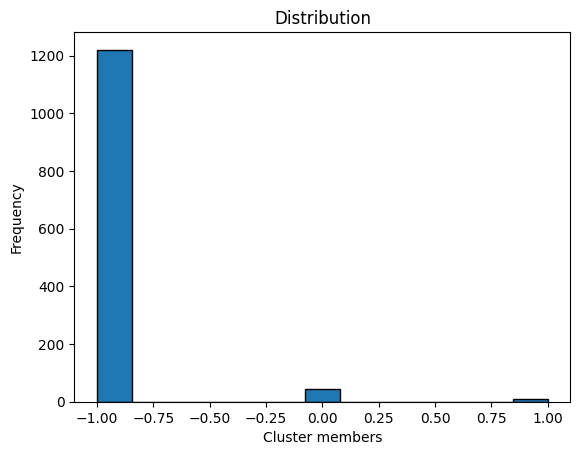

In [207]:
plt.hist(cluster.labels_, bins=13, edgecolor='k')
plt.xlabel('Cluster members')
plt.ylabel('Frequency')
plt.title('Distribution')
plt.show()

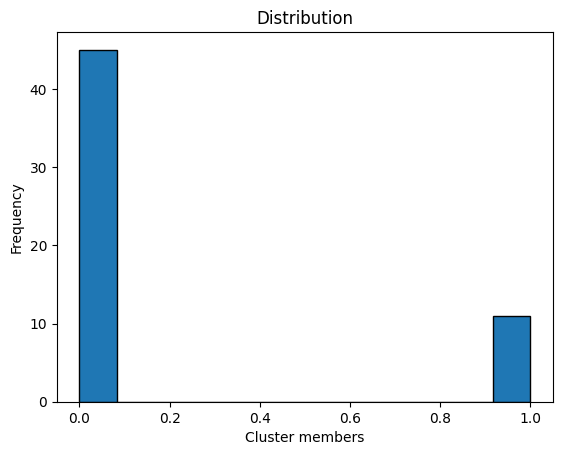

In [208]:
plt.hist(cluster.labels_[np.where(cluster.labels_>-1)], bins=12, edgecolor='k')
plt.xlabel('Cluster members')
plt.ylabel('Frequency')
plt.title('Distribution')
plt.show()

(5937, 64)
(1, 45, 64)
(1, 64)


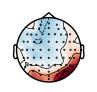

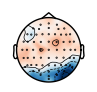

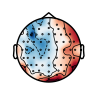

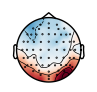

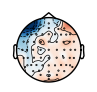

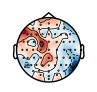

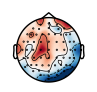

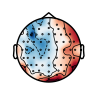

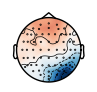

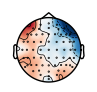

(<matplotlib.image.AxesImage at 0x1798a5787f0>,
 <matplotlib.contour.QuadContourSet at 0x1798a5da560>)

In [215]:
c12_indexes = np.where(cluster.labels_==0)
print(normalized.shape)
c12_gfp = normalized[c12_indexes, :]
print(c12_gfp.shape)
c12_gfp.reshape((45, 64))
print(c12_gfp[:, 0].shape)
mne.viz.plot_topomap(c12_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 10].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 44].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 5].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 22].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 33].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 40].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 44].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 30].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 20].flatten(), pos=raw.info)

(5937, 64)
(1, 11, 64)
(1, 64)


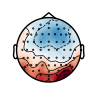

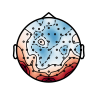

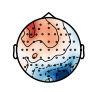

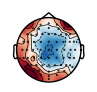

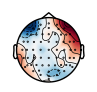

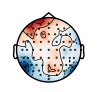

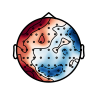

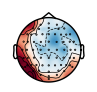

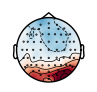

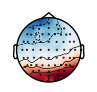

(<matplotlib.image.AxesImage at 0x179a5a88880>,
 <matplotlib.contour.QuadContourSet at 0x1798c754040>)

In [214]:
c12_indexes = np.where(cluster.labels_==1)
print(normalized.shape)
c12_gfp = normalized[c12_indexes, :]
print(c12_gfp.shape)
c12_gfp.reshape((11, 64))
print(c12_gfp[:, 0].shape)
mne.viz.plot_topomap(c12_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 1].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 3].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 4].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 5].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 6].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 7].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 8].flatten(), pos=raw.info)
mne.viz.plot_topomap(c12_gfp[:, 9].flatten(), pos=raw.info)